Appended base directory /media/aleksejs/DataHDD/work/codes/snippets-data-analysis/python/


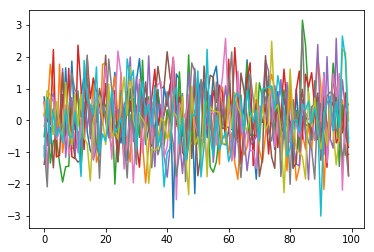

In [31]:
# Append base directory
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
base_dir = currentdir[:currentdir.index('python')] + 'python/'
sys.path.insert(0,base_dir) 
print("Appended base directory", base_dir)

# Import modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc
%matplotlib inline

# Import local libraries
from aux.stat import moments


# Test random number generator
np.random.seed()
NData = 100
NDataSet = 10
seqRandLst = np.random.normal(0, 1, NData*NDataSet).reshape((NDataSet, NData))
plt.figure()
for seqRand in seqRandLst:
    plt.plot(seqRand)
plt.show()

# Moments

The mean and variance of a random variable are defined as

$\mu(X) = \int_x x \rho(x) dx$

$\sigma^2(X) = \int_x (x - \mu_x)^2 \rho(x) dx$

For empirical estimates, an unbiased estimator for sample mean is average

$\mu(X) \approx \bar{X} = AVG(\vec{x}) = \frac{1}{N} \sum_i x_i$

Average mean squared error is a biased estimator of sample variance. An unbiased estimator is

$\sigma^2(X) \approx s^2(\vec{x}) = \frac{N-1}{N} AVG(\vec{x} - \mu(X))^2 = \frac{1}{N-1} \sum_i (x_i - \mu_x)^2$

Sample variance should converge to its analytical value with increasing measurement number. Variance of the mean of N samples can be show to scale as $1/N$ compared to sample variance, and should thus go to zero with increasing measurement number

$\sigma^2(\bar{X}) = \frac{1}{N} \sigma^2(X)$

Standard deviation is defined as $\sigma(X) = \sqrt{\sigma^2(X)}$

Sample standard deviation is approximately $s(\vec{x}) \approx \sqrt{s^2(\vec{x})}$. There is a small bias, for corrections see https://en.wikipedia.org/wiki/Standard_deviation

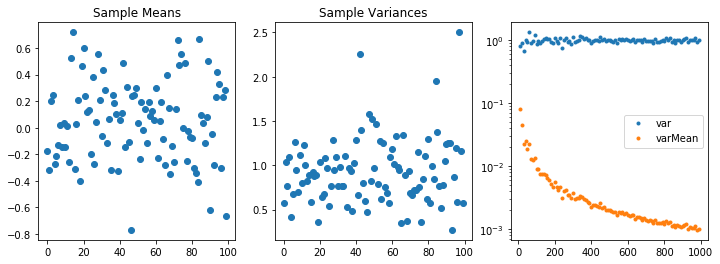

In [38]:
meanArr, varArr = moments.sample_mean_and_var(seqRandLst, axis = 0)

fig, ax = plt.subplots(ncols=3, figsize=(12, 4))

ax[0].plot(meanArr, 'o')
ax[0].set_title('Sample Means')

ax[1].plot(varArr, 'o')
ax[1].set_title('Sample Variances')

NDataArr = np.arange(10,1000, 10)
dataArr = np.array([np.random.normal(0, 1, i) for i in NDataArr])
varArr = [moments.sample_mean_and_var(data)[1] for data in dataArr]
varMeanArr = np.divide(varArr, NDataArr)

ax[2].semilogy(NDataArr, varArr, '.', label='var')
ax[2].semilogy(NDataArr, varMeanArr, '.', label='varMean')
ax[2].legend()

plt.show()

# Correlations

Pearson's correlation coefficient for two random variables is defined as

$CORR(X,Y) = \frac{COV(X,Y)}{\sigma_X \sigma_Y}$

where the covariance is given by 

$COV(X,Y) = \langle (X - \mu_X)(Y-\mu_Y) \rangle = \int_x \int_y \rho(xy) (x - \mu_x)(y- \mu_y)dx dy$

The unbiased sample covariance is given by

$COV(X,Y) \approx s^2(\vec{x}, \vec{y}) = \frac{1}{N-1}\sum_{i} (x_i - \mu_x)(y_i - \mu_y)$

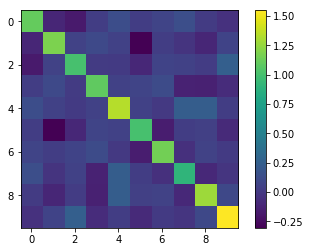

In [3]:
covmat = np.corrcoef(np.array(seqRandLst))

plt.figure()
covplot = plt.imshow(covmat)
covclrbar = plt.colorbar()

## Significance of high correlation

Assume the data $X$, $Y$ have the same range. We would like to construct a test

$CORR(X,Y) > \lambda_N$

to determine if the noisy data was drawn from the same distribution or not. Here $\lambda_N$ is some constant function of the number $N$ of datapoints. For small sample sizes, covariance can be significantly non-zero even for random uncorrelated datasets. Let us investigate by how much

### Test 1: Effect of number of sample points

For 2 independent random variables, their sample correlation is equal to

$CORR(X, Y) \approx \frac{1}{\sigma_X \sigma_Y}\frac{1}{N-1}\sum_{i} (x_i - \mu_x)(y_i - \mu_y) \sim \frac{1}{\sigma_X \sigma_Y}\mathcal{N}(0, \frac{VAR(xy)}{N}) \approx \mathcal{N}(0, \frac{1}{N})$

where the joint variance simply decomposes to $VAR(xy) = VAR(x)VAR(y)$

No strong dependence on variance or exact distribution observed.

### Test 2: What is then the probability of getting a correlation greater than a certain value

$P[\mathrm{abs}(CORR) > \alpha] = 1 - \int_{-\alpha \sqrt{N}}^{\alpha \sqrt{N}} \rho_{\mathcal{N}(0,1)}(x)dx = 1 - erf\bigl(\alpha\sqrt{\frac{N}{2}} \bigr) = erfc\bigl(\alpha\sqrt{\frac{N}{2}} \bigr) \approx \frac{exp(-\alpha N /2)}{\sqrt{\pi \alpha N / 2}}$

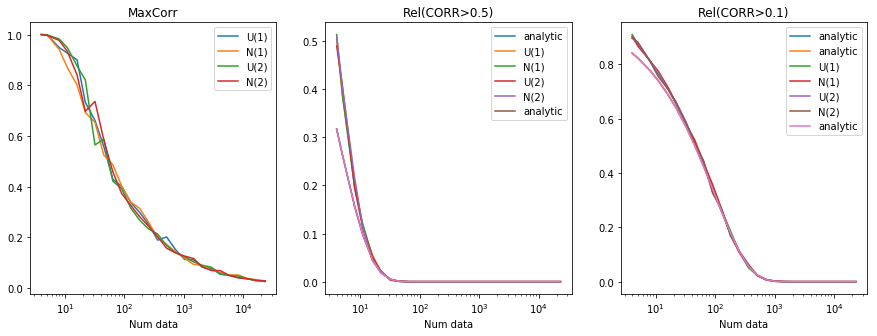

In [37]:
def distrFunc(name, std, NData, NDataSet):
    if name == "U":
        return np.random.uniform(0, std*np.sqrt(12), NDataSet*NData).reshape((NDataSet, NData))
    elif name == "N":
        return np.random.normal(0, std, NDataSet*NData).reshape((NDataSet, NData))
    else:
        raise ValueError("Unknown Distribution", name)
        
# Number of datapoints to use for each experiment
NDataArr = (2**np.arange(2, 15, 0.5)).astype(int)
NDataArrLen = len(NDataArr)

# Number of trials to use for each experiment
NDataSet = 100

# Number of elements in upper-triangular correlation
NElemTriu = NDataSet * (NDataSet - 1) / 2

# Distributions
NDistr = 4
distrNames = ["U","N","U","N"]
distrStd = [1,1,2,2]
distrLabels = [distrNames[i] + "(" + str(distrStd[i]) + ")" for i in range(NDistr)]

# Tests
NTest = 3
testNames = ["MaxCorr", "Rel(CORR>0.5)", "Rel(CORR>0.1)"]
corrTestRez = np.zeros((NDataArrLen, NDistr, NTest))


for iNData in range(NDataArrLen):
    NData = NDataArr[iNData]
    
    for iDistr in range(NDistr):
        # Compute the random distribution
        distr = distrFunc(distrNames[iDistr], distrStd[iDistr], NData, NDataSet)
    
        # Calculate mean and average off-diagonal covariance
        corrMatAbsTriU = np.abs(np.triu(np.corrcoef(distr), 1))
        
        corrTestRez[iNData, iDistr, 0] = np.max(corrMatAbsTriU)
        corrTestRez[iNData, iDistr, 1] = np.sum(corrMatAbsTriU > 0.5) / NElemTriu
        corrTestRez[iNData, iDistr, 2] = np.sum(corrMatAbsTriU > 0.1) / NElemTriu
    

# Plot Averages
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))

for iTest in range(NTest):
    for iDistr in range(NDistr):
        ax[iTest].semilogx(NDataArr, corrTestRez[:, iDistr, iTest], label=distrLabels[iDistr])
        
    ax[1].semilogx(NDataArr, erfc(0.5 * np.sqrt(NDataArr / 2)), label="analytic")
    ax[2].semilogx(NDataArr, erfc(0.1 * np.sqrt(NDataArr / 2)), label="analytic")
    
    ax[iTest].set_xlabel('Num data')
    ax[iTest].set_title(testNames[iTest])
    ax[iTest].legend()

plt.show()